## Multi-objective optimization for perovskite material composition
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR to design experiments. Here, we show how to load some data from a presampling, and how to use BOAR to suggest the next set of experiment using Bayesian optimization.
The goal here is to do multi-objective optimization (MO) to maximize the phololuminescence quantum yield (PLQY) and minimize the full width at half maximum (FWHM) of a perovskite thin film.

Note: The data used here is real data generated in the [i-MEET](https://www.i-meet.ww.uni-erlangen.de/) and [HI-ERN](https://www.hi-ern.de/de) labs at the university of Erlangen-Nuremberg (FAU) by Frederik Schmitt. The data is not published yet, and is only used here for demonstration purposes. For more information, please contact us.

In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# # comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook
import plotly.io as pio # comment out to only render png
pio.renderers.default = 'png'

# Import libraries
import sys,os,types,copy
import warnings
import pandas as pd
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *
from boar.core.optimization_botorch import *
# import additional libraries from Ax
from ax.utils.notebook.plotting import render, init_notebook_plotting # for plotting in notebook
from ax.plot.slice import plot_slice
from ax.plot.scatter import interact_fitted,plot_objective_vs_constraints,tile_fitted
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.contour import interact_contour
from ax.plot.diagnostic import interact_cross_validation
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier
# Import homemade package by VLC
# import boar.SIMsalabim_utils.plot_settings_screen # to set default plot settings


In [2]:
# Define the path to the data 
curr_dir = os.getcwd() # current directory
res_dir = os.path.join(os.path.abspath('../'),'temp') # path to the results directory
data_dir = os.path.join(os.path.abspath('../'),'Example_Data') 

In [3]:
names = ['status', 'campaign_name', 'iteration', 'batch_number',
       'Cs_fraction',
       'Fa_fraction',
       'Ma_fraction',
       'Spin_duration_Antisolvent',
       'Spin_duration_High_Speed',
       'Spin_speed',
       'FWHM',
       'PLQY', 'merit', 'updated_date']
df = pd.read_csv(os.path.join(data_dir, 'Frederik','Pero_PLQY_FWHM.csv'), names=names, header=0)
print(df.head())

  status   campaign_name  iteration  batch_number  Cs_fraction  Fa_fraction  \
0     ok  Pero 2 Targets          0             0         0.15         0.40   
1     ok  Pero 2 Targets          0             1         0.30         0.60   
2     ok  Pero 2 Targets          0             2         0.70         0.15   
3     ok  Pero 2 Targets          0             3         0.20         0.40   
4     ok  Pero 2 Targets          0             4         0.85         0.00   

   Ma_fraction  Spin_duration_Antisolvent  Spin_duration_High_Speed  \
0         0.45                       17.0                      56.0   
1         0.10                       24.0                      54.0   
2         0.15                       26.0                      27.0   
3         0.40                       27.0                      25.0   
4         0.15                       30.0                      54.0   

   Spin_speed    FWHM  PLQY     merit                 updated_date  
0      1000.0   52.38  1.02  

In [4]:
params_names = ['Cs_fraction','Fa_fraction','Spin_duration_Antisolvent','Spin_duration_High_Speed','Spin_speed']
target_names = ['FWHM','PLQY']
df_filtered = copy.deepcopy(df[params_names+target_names])
df_filtered = df_filtered.drop_duplicates()
df_filtered = df_filtered.dropna()

stepsize_fraction = 0.05
stepsize_spin_speed = 100

# transform the data to the right format
df_filtered['Cs_fraction'] = df_filtered['Cs_fraction'].apply(lambda x: float(round(x/stepsize_fraction)))
df_filtered['Fa_fraction'] = df_filtered['Fa_fraction'].apply(lambda x: float(round(x/stepsize_fraction)))
df_filtered['Spin_duration_Antisolvent'] = df_filtered['Spin_duration_Antisolvent'].apply(lambda x: round(x))
df_filtered['Spin_duration_High_Speed'] = df_filtered['Spin_duration_High_Speed'].apply(lambda x: round(x))
df_filtered['Spin_speed'] = df_filtered['Spin_speed'].apply(lambda x: round(x/stepsize_spin_speed))

dic = {'x':[],'y_0':[],'ydyn_0':1,'y_1':[],'ydyn_1':1}
for num in range(len(df_filtered)):
    dic['x'].append(df_filtered[params_names].iloc[num].values.tolist())
    dic['y_0'].append(df_filtered[target_names[0]].iloc[num])
    dic['y_1'].append(df_filtered[target_names[1]].iloc[num])

# save to res_dir
with open(os.path.join(res_dir,'old_XY.json'), 'w') as fp:
    json.dump(dic, fp)



# Define the free parameters to be optimized

In [5]:
params = []

Cs_fraction = Fitparam(name = 'Cs_fraction', val =  0, lims = [0, int(1/stepsize_fraction)], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Cs fraction', unit = 'nm',rescale=False)
params.append(Cs_fraction)
Fa_fraction = Fitparam(name = 'Fa_fraction', val =  0, lims = [0, int(1/stepsize_fraction)], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'FA fraction', unit = 'nm',rescale=False)
params.append(Fa_fraction)
Spin_duration_Antisolvent = Fitparam(name = 'Spin_duration_Antisolvent', val =  5, lims = [5, 30], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Spin duration Antisolvent', unit = 's',val_type='int')
params.append(Spin_duration_Antisolvent)
Spin_duration_High_Speed = Fitparam(name = 'Spin_duration_High_Speed', val =  20, lims = [15, 60], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Spin duration High Speed', unit = 's',val_type='int')
params.append(Spin_duration_High_Speed)
Spin_speed = Fitparam(name = 'Spin_speed', val =  20, lims = [10, 60], relRange = 1, range_type = 'lin',
            lim_type = 'absolute',optim_type='lin', display_name = 'Spin speed', unit = 'RPM',val_type='int') # reall spin speed is param*100
params.append(Spin_speed)

In [6]:
# create an excel file with len(params) columns and nb_new_exp rows filled with nan
nb_new_exp = 9
dat_array = np.zeros((nb_new_exp, len(params))).tolist()
# replace all with 'nan'
for i in range(len(dat_array)):
    for j in range(len(dat_array[i])):
        dat_array[i][j] = 'nan'
pnames = [ p.name for p in params ]
df = pd.DataFrame(dat_array, columns=pnames)
df.to_excel(os.path.join(res_dir,'BOAR_Exp.xlsx'), index=False)

df2 = pd.read_excel(os.path.join(res_dir,'BOAR_Exp.xlsx'))
print(df2)
def exp_to_df(X,params):
    pass

   Cs_fraction  Fa_fraction  Spin_duration_Antisolvent  \
0          NaN          NaN                        NaN   
1          NaN          NaN                        NaN   
2          NaN          NaN                        NaN   
3          NaN          NaN                        NaN   
4          NaN          NaN                        NaN   
5          NaN          NaN                        NaN   
6          NaN          NaN                        NaN   
7          NaN          NaN                        NaN   
8          NaN          NaN                        NaN   

   Spin_duration_High_Speed  Spin_speed  
0                       NaN         NaN  
1                       NaN         NaN  
2                       NaN         NaN  
3                       NaN         NaN  
4                       NaN         NaN  
5                       NaN         NaN  
6                       NaN         NaN  
7                       NaN         NaN  
8                       NaN         NaN  

# Start the optimization

In [7]:
# Define the targets and the model for the TM problem
X_dimensions = ['_']
y_dimension = 'FWHM'
target = {'model':exp_to_df,'target_name':'FWHM','minimize':True,
          'data':{'X':[0],'y':[0],'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':'nm'}
            ,'target_weight':1, 'weight':1}

y_dimension = 'PLQY'
target2 = {'model':exp_to_df,'target_name':'PLQY','minimize':False,
          'data':{'X':[0],'y':[100],'X_dimensions':X_dimensions,'X_units':['s',''],'y_dimension':y_dimension,'y_unit':'%'}
            ,'target_weight':1, 'weight':1}

targets = [target,target2]
obj_type='identity'
loss='linear'
threshold=[50,0.5]

mo = MooBOtorch(params=params, targets= targets) # initialize the optimization object
mo.warmstart = 'recall'
mo.parallel = False # needed if number of cores is lower than number of CPU - 1 to ensure we output the right number of points
# mo.SaveOldXY2file = os.path.join(res_dir,'old_XY.json')
mo.Path2OldXY = os.path.join(res_dir,'old_XY.json')
mo.parameter_constraints = [f'{stepsize_fraction}*Cs_fraction + {stepsize_fraction}*Fa_fraction <= 1']

# Define custom evaluation function
def evaluate_custom(self,px,obj_type,loss,threshold=1,is_MOO=True):
  pass
  

mo.evaluate_custom = types.MethodType(evaluate_custom, mo) # add the method to the object FullyBayesianMOO
kwargs_posterior = {'Nres':10,'Ninteg':1e3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':None,'show_points':True,'savefig':False,'figname':'param_posterior','full_grid':True,'randomize':True}

ax_client = mo.BoTorchOpti(n_jobs=[nb_new_exp], n_step_points = [nb_new_exp], models=['MOO'],obj_type=obj_type,loss=loss,threshold=threshold,use_CUDA=True,is_MOO=True,verbose=True,show_posterior=False,kwargs_posterior=kwargs_posterior,use_custom_func=False,suggest_only=True)

[INFO 09-20 09:59:35] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 09-20 09:59:35] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='Cs_fraction', parameter_type=FLOAT, range=[0.0, 20.0]), RangeParameter(name='Fa_fraction', parameter_type=FLOAT, range=[0.0, 20.0]), RangeParameter(name='Spin_duration_Antisolvent', parameter_type=INT, range=[5, 30]), RangeParameter(name='Spin_duration_High_Speed', parameter_type=INT, range=[15, 60]), RangeParameter(name='Spin_speed', parameter_type=INT, range=[10, 60])], parameter_constraints=[ParameterConstraint(0.05*Cs_fraction + 0.05*Fa_fraction <= 1.0)]).
[INFO 09-20 09:59:35] ax.core.experiment: Attached custom parameterizations [{'Cs_fraction': 3.0, 'Fa_fraction': 8.0, 'Spin_duration_Antisolvent': 17, 'Spin_duration_High_Speed': 56, 'Spin_sp

In [8]:
# Print the optimized stack structure
for p in mo.params:
    if p.val_type != 'str':
        print(p.display_name + f' {p.val:.0f} ')
        print(p.lims)
    else:
        print(p.display_name + f' {p.val}')

Cs fraction 0 
[0, 20]
FA fraction 4 
[0, 20]
Spin duration Antisolvent 6 
[5, 30]
Spin duration High Speed 41 
[15, 60]
Spin speed 45 
[10, 60]


In [9]:
# get all tried data from the ax_client
triedX = ax_client.generation_strategy.trials_as_df
# print(triedX.tail())
triedY = ax_client.experiment.fetch_data().df
# print(triedY.tail())

# find Trial Status ABANDONED
abandoned_trials = triedX[triedX['Trial Status']=='ABANDONED']
dics = []
for index, row in abandoned_trials.iterrows():
    
    dic_dum = abandoned_trials['Arm Parameterizations'][index]
    key = list(dic_dum.keys())[0]
    dic = dic_dum[key]
    dics.append(dic)

# put in a dataframe
df2try = pd.DataFrame(dics)

df2try['Cs_fraction'] = round(df2try['Cs_fraction']) * stepsize_fraction
df2try['Fa_fraction'] = round(df2try['Fa_fraction']) * stepsize_fraction
df2try['Ma_fraction'] = 1 - df2try['Cs_fraction'] - df2try['Fa_fraction']
df2try['Spin_speed'] = round(df2try['Spin_speed']) * stepsize_spin_speed 

# save to excel
df2try.to_excel(os.path.join(res_dir,'BOAR_Exp_2_try.xlsx'))

print(df2try)

[INFO 09-20 10:00:21] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


   Cs_fraction  Fa_fraction  Spin_duration_Antisolvent  \
0          0.0         0.95                         17   
1          0.0         0.70                          9   
2          0.0         0.85                         14   
3          0.0         0.50                         21   
4          0.0         0.75                          5   
5          0.0         0.95                         16   
6          0.0         0.75                          5   
7          0.0         0.05                         23   
8          0.0         0.70                         15   

   Spin_duration_High_Speed  Spin_speed  Ma_fraction  
0                        51        2700         0.05  
1                        38        3000         0.30  
2                        33        3100         0.15  
3                        37        2500         0.50  
4                        51        3000         0.25  
5                        47        1300         0.05  
6                        33       

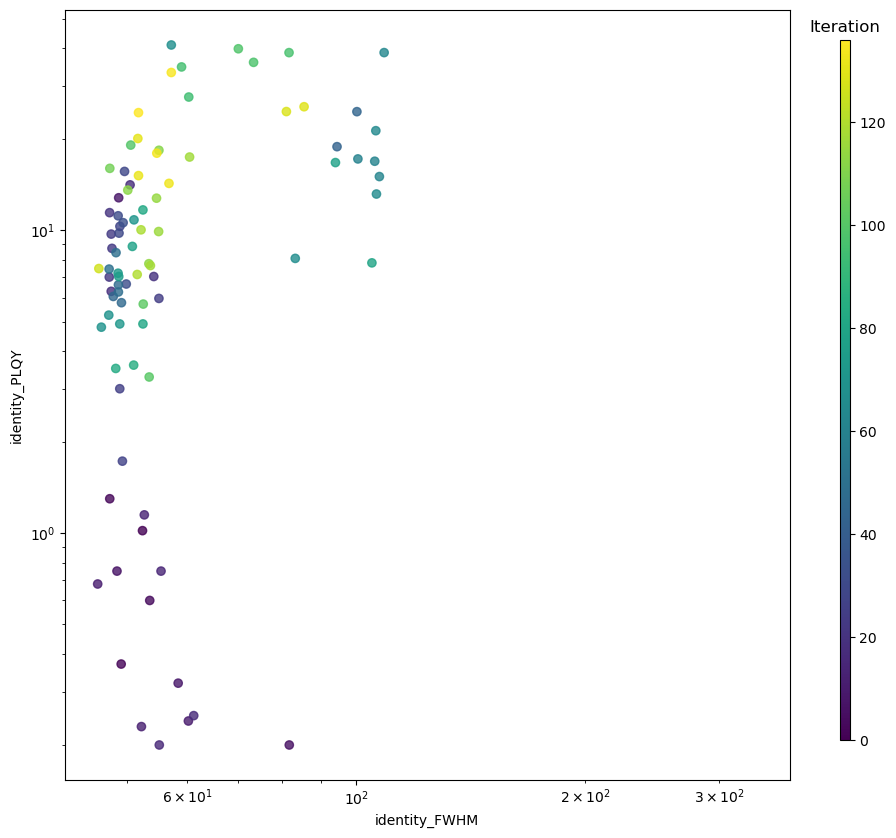

In [10]:
# Plot the Pareto front of the test problem
mo.plot_all_objectives(ax_client,logscale=True,figsize=(10,10))

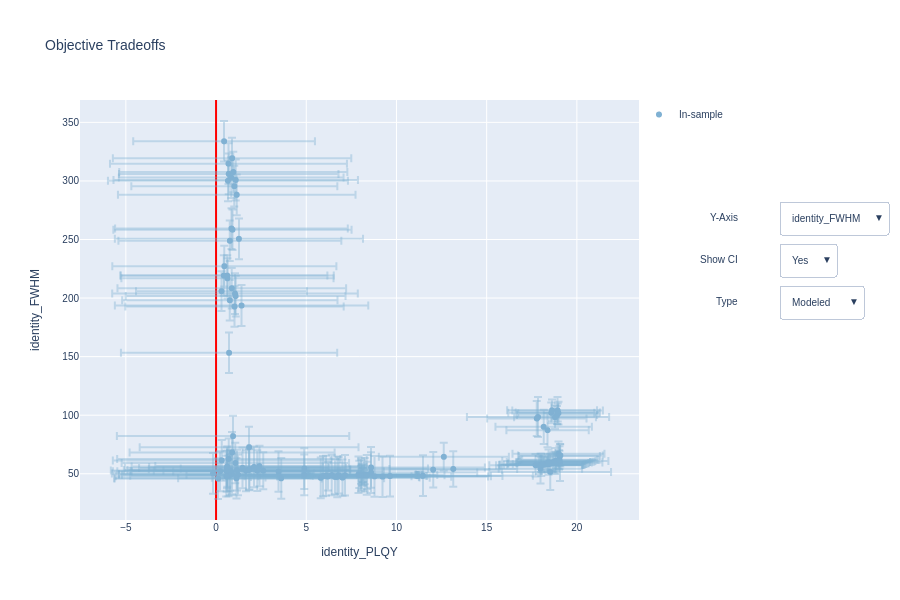

In [11]:
# Interactive plotting of the objective function tradeoffs
model = ax_client.generation_strategy.model
render(plot_objective_vs_constraints(model, 'identity_PLQY', rel=False))

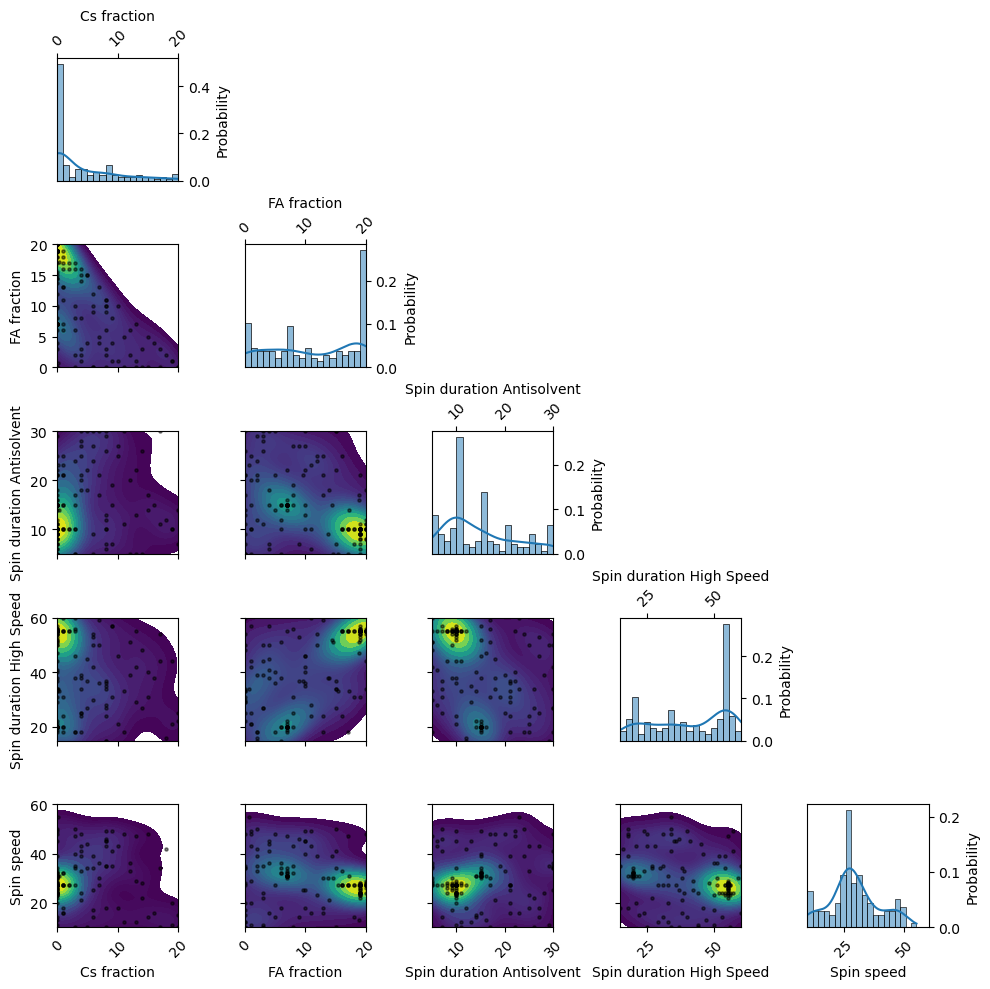

In [12]:
# Plot the density of points that were sampled during the optimization process
mo.plot_density(ax_client,figsize=(10,10))

[INFO 09-20 10:00:25] ax.service.ax_client: Retrieving contour plot with parameter 'Cs_fraction' on X-axis and 'Spin_speed' on Y-axis, for metric 'identity_FWHM'. Remaining parameters are affixed to the middle of their range.


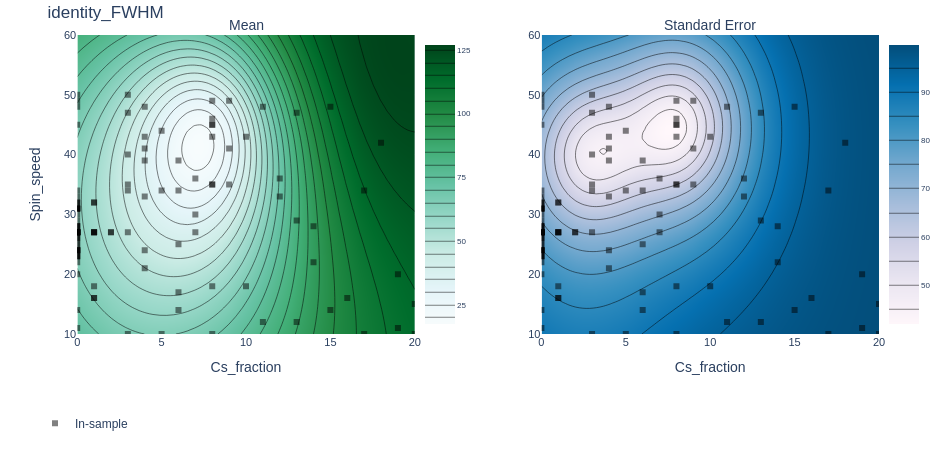

In [13]:
# Plot the contour of the objective function for a given target
render(ax_client.get_contour_plot(param_x=params[0].name, param_y=params[-1].name, metric_name=obj_type+'_'+target['target_name']))

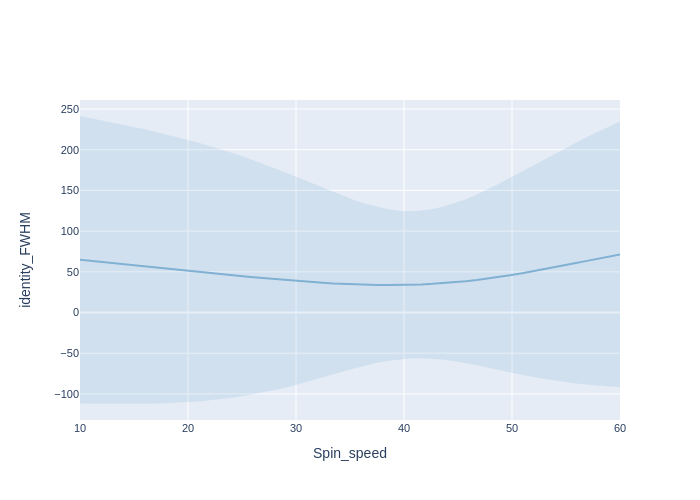

In [14]:
# Plot the slice (i.e., 1D projection) of the model along the a single dimension 
render(plot_slice(model, params[-1].name, obj_type+'_'+target['target_name']))

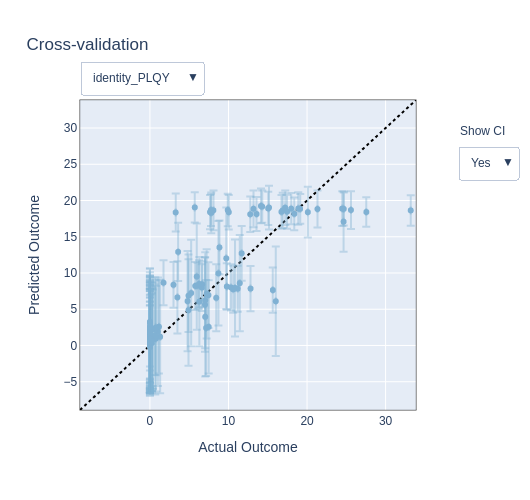

In [15]:
# Plot the results of cross validation
cv_results = cross_validate(model)
render(interact_cross_validation(cv_results))

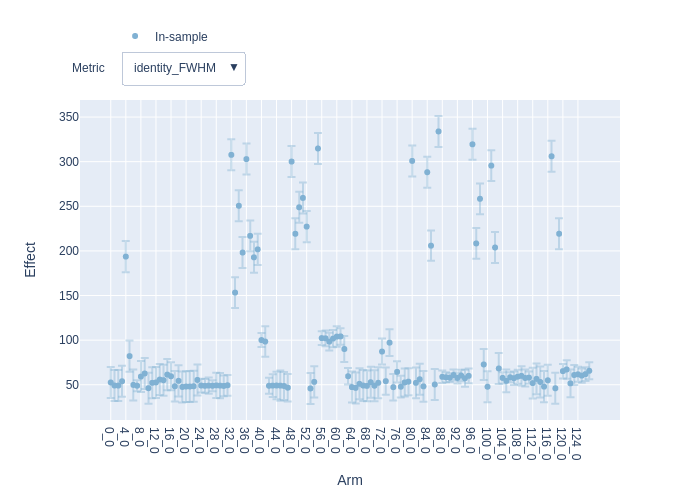

In [16]:
# Interactive plot of the target during the optimization process
render(interact_fitted(model, rel=False))

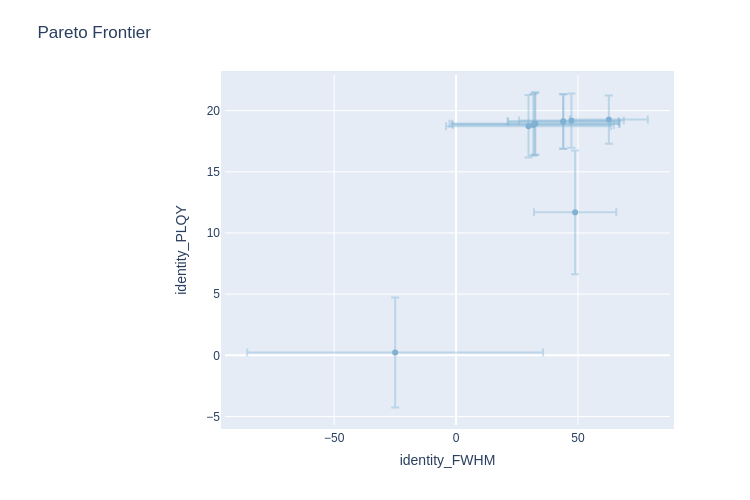

In [18]:
# Compute and plot the Pareto frontier
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=['identity_PLQY', 'identity_FWHM'],
    num_points=10,
)
render(plot_pareto_frontier(frontier, CI_level=0.90)) 